 # Applying the water balance equation



 ## Objectives

 - Apply the water balance equation to real-world data

 - Test the impact of land cover on the runoff ratio

 - Fit a simple statistical model to data



 ## Prerequisites:

 - Basic understanding of Python

 - Familiarity with Pandas, Matplotlib

 ## Dataset

 We will be using the CAMELS-GB dataset. This contains daily hydrometeorological data for around 670 catchments in Great Britain, as well as catchment attributes related to land use/land cover, geology, and climate. Download the data [here](https://catalogue.ceh.ac.uk/documents/8344e4f3-d2ea-44f5-8afa-86d2987543a9), then upload it to the (currently) empty `data` folder in this repository. Now extract the data archive: 

In [1]:
import os
import zipfile

zip_path = 'data/8344e4f3-d2ea-44f5-8afa-86d2987543a9.zip'
extract_dir = 'data/8344e4f3-d2ea-44f5-8afa-86d2987543a9'

if not os.path.isdir(extract_dir):
    try:
        with zipfile.ZipFile(zip_path, 'r') as archive:
            archive.extractall('data')
    except FileNotFoundError:
        print(f"Zip file {zip_path} not found.")
    except zipfile.BadZipFile:
        print(f"Zip file {zip_path} is corrupt.")

Let's create a path variable so that we can easily navigate to the data files:

In [2]:
import os
DATADIR = os.path.join('data', '8344e4f3-d2ea-44f5-8afa-86d2987543a9', 'data')


 Now Load the data for a catchment chosen at random. The timeseries data are stored as csv files, so we use Pandas to load them into a Pandas DataFrame object:

In [3]:
import pandas as pd
id = '97002'
data = pd.read_csv(os.path.join(DATADIR, 'timeseries', f'CAMELS_GB_hydromet_timeseries_{id}_19701001-20150930.csv'), parse_dates=[0])
data.head()


,date,precipitation,pet,temperature,discharge_spec,discharge_vol,peti,humidity,shortwave_rad,longwave_rad,windspeed
0,1970-10-01,9.93,1.02,8.91,NaN,NaN,1.31,6.01,61.76,325.33,7.65
1,1970-10-02,4.01,1.41,7.66,NaN,NaN,1.76,5.11,93.56,294.20,10.03
2,1970-10-03,7.27,1.17,8.77,NaN,NaN,1.40,5.41,61.95,321.14,5.41
3,1970-10-04,3.77,0.06,9.74,NaN,NaN,0.23,7.76,42.83,341.28,7.27
4,1970-10-05,1.19,1.56,9.46,NaN,NaN,1.86,5.49,92.13,299.08,7.90


 Later on it will be useful to have the catchment ID in the dataframe, so we add it here:

In [4]:
data['id'] = id


We can also see that the `discharge_vol` column contains `NaN` values - these usually indicate missing data. There are various things we can do to handle (or impute) missing values, but for now let's just remove them: 

In [5]:
data = data.dropna(subset=['discharge_vol'])
data.head()

,date,precipitation,pet,temperature,discharge_spec,discharge_vol,peti,humidity,shortwave_rad,longwave_rad,windspeed,id
457,1972-01-01,0.00,0.21,3.92,1.12,5.37,0.21,4.20,15.49,284.96,4.77,97002
458,1972-01-02,0.84,0.20,3.66,1.05,5.03,0.32,4.53,8.64,311.41,5.63,97002
459,1972-01-03,2.09,0.31,3.69,1.08,5.20,0.44,4.25,8.75,310.61,4.49,97002
460,1972-01-04,1.38,0.01,3.09,1.19,5.73,0.01,4.34,5.78,308.46,2.29,97002
461,1972-01-05,0.47,0.02,2.61,1.12,5.37,0.03,4.03,9.34,304.41,1.72,97002


 Recall the water balance equation from lecture 1:

 $\frac{dS}{dt} = P - E - Q$

 where $\frac{dS}{dt}$ is the change in storage over time, $P$ is precipitation, $E$ is evaporation and $Q$ is streamflow. Also recall that over long time periods we can assume the storage term tends towards zero. Now we can write:

 $0 = P - E - Q$

 and hence:

 $E = P - Q.$

 This is convenient because evaporation is hard to measure accurately. Let's use the equation above to estimate the catchment-averaged evaporation. We will work at annual timescales so that we can reasonably assume that the storage term is negligible. First we need to compute the annual precipitation and discharge. To do this we typically use the "water year" instead of the calendar year. This avoids the potential for large errors in the water balance because catchment storage can vary significantly during the wet season. In the UK the water year is taken as 1st October to 30th September. Fortunately Pandas has some magic that allows us to easily aggregate by water year:

In [6]:
data['water_year'] = data['date'].dt.to_period('Y-SEP')
data.head()


,date,precipitation,pet,temperature,discharge_spec,discharge_vol,peti,humidity,shortwave_rad,longwave_rad,windspeed,id,water_year
457,1972-01-01,0.00,0.21,3.92,1.12,5.37,0.21,4.20,15.49,284.96,4.77,97002,1972
458,1972-01-02,0.84,0.20,3.66,1.05,5.03,0.32,4.53,8.64,311.41,5.63,97002,1972
459,1972-01-03,2.09,0.31,3.69,1.08,5.20,0.44,4.25,8.75,310.61,4.49,97002,1972
460,1972-01-04,1.38,0.01,3.09,1.19,5.73,0.01,4.34,5.78,308.46,2.29,97002,1972
461,1972-01-05,0.47,0.02,2.61,1.12,5.37,0.03,4.03,9.34,304.41,1.72,97002,1972


 Here, `A-SEP` is a period alias for "annual frequency, anchored end of September". Learn more about period aliases by consulting the [Pandas documentation](https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-period-aliases).



 We also need to convert the discharge from m3/s to m3/day:

 Now we group our dataframe by the new `water_year` column, and compute the sum of precipitation and discharge:

In [7]:
data['discharge_vol'] *= 60 * 60 * 24
data = data.groupby(['id', 'water_year'])[['precipitation', 'pet', 'discharge_spec', 'discharge_vol']].sum().reset_index()


 Aggregating data is an extremely useful skill in hydrology. Think about how you might use Pandas to aggregate by month or by season.



 When making comparisons between catchments, it is common to transform all variables to a *depth* so that the effect of catchment area is reduced. This allows us to compare the hydrological behaviour of a large catchment (e.g. Tweed) with a much smaller catchment. Let's load the catchment attributes and find the area of our catchment.

In [8]:
metadata = pd.read_csv(os.path.join(DATADIR, f'CAMELS_GB_topographic_attributes.csv'))
metadata['gauge_id'] = metadata['gauge_id'].astype(str)
area = metadata[metadata['gauge_id'] == id]['area'].values[0]
area *= 1e6 # km2 -> m2 


 Now we can transform our data to mm/day:

In [9]:
data['discharge_vol'] /= area # m3 -> m
data['discharge_vol'] *= 1000 # m -> mm


 If you look at the dataframe, you see that column `discharge_vol` is now the same as `discharge_spec`. In future, you can use `discharge_spec` directly, without the need for transformation. We now have everything we need to estimate evaporation using the water balance equation:

In [10]:
data['evaporation'] = data['precipitation'] - data['discharge_vol']


 Let's plot this data:

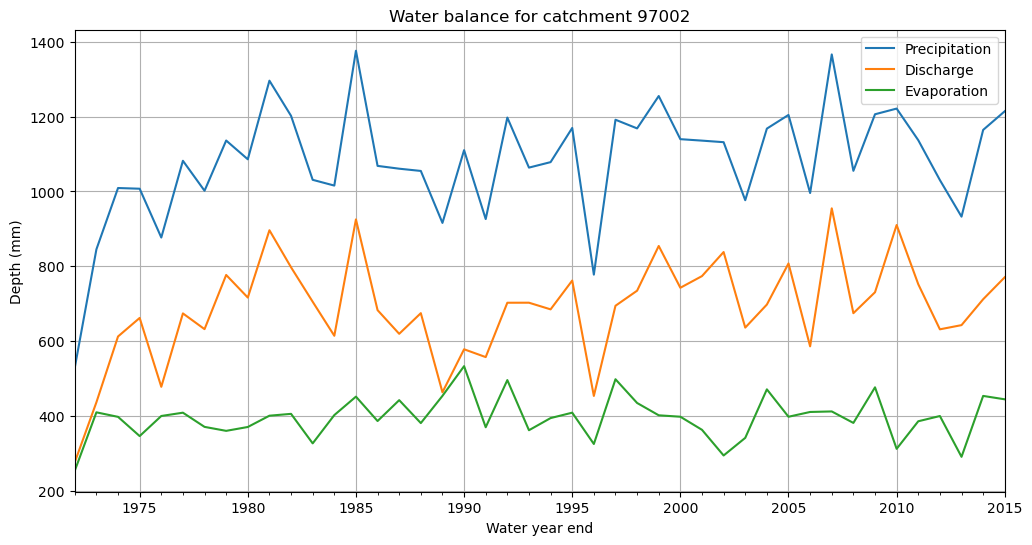

In [11]:
import matplotlib.pyplot as plt

data = data.set_index('water_year')
data.plot(y=['precipitation', 'discharge_spec', 'evaporation'], figsize=(12, 6))

plt.title(f'Water balance for catchment {id}')
plt.xlabel('Water year end')
plt.ylabel('Depth (mm)')
plt.legend(['Precipitation', 'Discharge', 'Evaporation'])
plt.grid(True)
plt.show()

data = data.reset_index()

 ## Land cover impacts

 We will cover the drivers of evaporation in more detail later on the course. One question we may have is the role of different land cover types on the water balance. Let's investigate whether land use impacts evaporation by looking at some forested catchments:

In [12]:
metadata_lu = pd.read_csv(os.path.join(DATADIR, f'CAMELS_GB_landcover_attributes.csv')) 
metadata_lu.head()

,gauge_id,dwood_perc,ewood_perc,grass_perc,shrub_perc,crop_perc,urban_perc,inwater_perc,bares_perc,dom_land_cover
0,10002,3.89,5.41,42.48,6.16,40.37,1.72,0.13,0.01,Grass and Pasture
1,10003,4.74,3.06,36.88,0.31,54.06,1.04,0.06,0.03,Crops
2,1001,0.41,12.37,39.84,41.89,1.78,0.21,3.36,0.30,Shrubs
3,101002,6.20,0.30,42.78,0.38,46.34,3.28,0.49,0.56,Crops
4,101005,4.60,0.12,59.24,0.25,31.08,4.78,0.05,0.00,Grass and Pasture


 Have a look at the columns in `metadata_lu` and consult Coxon et al. (2020). Which columns represent forest? Create a new column called `forest_perc` that combines the two types.

In [16]:
metadata_lu['forest_perc'] = metadata_lu[['ewood_perc', 'dwood_perc']].sum(axis=1)
metadata_lu[['gauge_id', 'dwood_perc', 'ewood_perc', 'forest_perc']].head()

,gauge_id,dwood_perc,ewood_perc,forest_perc
0,10002,3.89,5.41,9.30
1,10003,4.74,3.06,7.80
2,1001,0.41,12.37,12.78
3,101002,6.20,0.30,6.50
4,101005,4.60,0.12,4.72


 Now identify catchments with more than 20% forest:

In [21]:
metadata_lu = metadata_lu.loc[metadata_lu['forest_perc'] >= 20.]
forest_catchment_ids = metadata_lu['gauge_id'].to_list()

 To compare the impact of vegetation on runoff generation, it would be useful to compute a summary measure for each catchment. One such measure, or signature, is the runoff ratio, defined as the proportion of precipitation that becomes runoff. We can calculate this as follows:

In [ ]:
data_sum = data.groupby('id')[['precipitation', 'discharge_vol']].sum()


 Now we can calculate the runoff ratio:

In [ ]:
data_sum['runoff_ratio'] = data_sum['discharge_vol'] / data_sum['precipitation']


 ## Optional exercise

 Compute the runoff ratio for every catchment with greater than 20% forest (HINT: write a loop to perform the necessary steps). Using `statsmodels`, fit a linear regression model to the data to test the hypothesis that runoff ratio is related to the forest extent.

In [29]:
def read_camels_data(id): 
    data = pd.read_csv(os.path.join(DATADIR, 'timeseries', f'CAMELS_GB_hydromet_timeseries_{id}_19701001-20150930.csv'), parse_dates=[0])
    return data 

def compute_runoff_ratio(data):
    data_sum = data.groupby('id')[['precipitation', 'discharge_spec']].sum()
    data_sum['runoff_ratio'] = data_sum['discharge_spec'] / data_sum['precipitation']
    #data_sum = data_sum[['id', 'runoff_ratio']]
    return data_sum

from tqdm import tqdm

rr_list = []
for id in tqdm(forest_catchment_ids): 
    data = read_camels_data(id)
    data['id'] = id
    rr = compute_runoff_ratio(data)
    rr_list.append(rr)

rr = pd.concat(rr_list)
rr = rr.merge(metadata_lu, how='left', left_on='id', right_on='gauge_id')
rr.head()


100%|██████████| 133/133 [00:03<00:00, 40.40it/s]


,precipitation,discharge_spec,runoff_ratio,gauge_id,dwood_perc,ewood_perc,grass_perc,shrub_perc,crop_perc,urban_perc,inwater_perc,bares_perc,dom_land_cover,forest_perc
0,52895.59,24853.01,0.469850,12008,2.55,18.11,11.68,65.41,2.18,0.12,0.04,0.00,Shrubs,20.66
1,40673.81,19805.88,0.486944,13001,3.57,16.55,23.25,3.92,51.87,0.98,0.00,0.00,Crops,20.12
2,41973.16,16088.01,0.383293,15021,14.70,7.04,28.73,21.30,22.70,1.84,3.81,0.00,Grass and Pasture,21.74
3,63438.08,34593.63,0.545313,15023,1.61,20.03,31.57,45.02,0.33,0.04,1.22,0.22,Shrubs,21.64
4,73958.62,41217.65,0.557307,17001,5.16,27.94,38.74,17.04,2.67,3.53,4.68,0.36,Grass and Pasture,33.10


We now have a dataframe containing our dependent variable (`runoff_ratio`) and our independent variable (`forest_perc`). Now let's fit a linear regression model to see if the two are related: 

In [34]:
import statsmodels.api as sm

X = rr["forest_perc"]
y = rr["runoff_ratio"]

# Add a constant to the predictor for the intercept term
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           runoff_ratio   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.048
Date:                Wed, 15 Jan 2025   Prob (F-statistic):             0.0832
Time:                        20:10:50   Log-Likelihood:                 28.633
No. Observations:                 133   AIC:                            -53.27
Df Residuals:                     131   BIC:                            -47.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4582      0.044     10.333      

This suggests that, using linear regression, we cannot reject the null hypothesis that the runoff ratio is not related to forest cover $p>0.05$. However, it is possible that linear regression is not the most suitable model. Let's visualize the relationship:

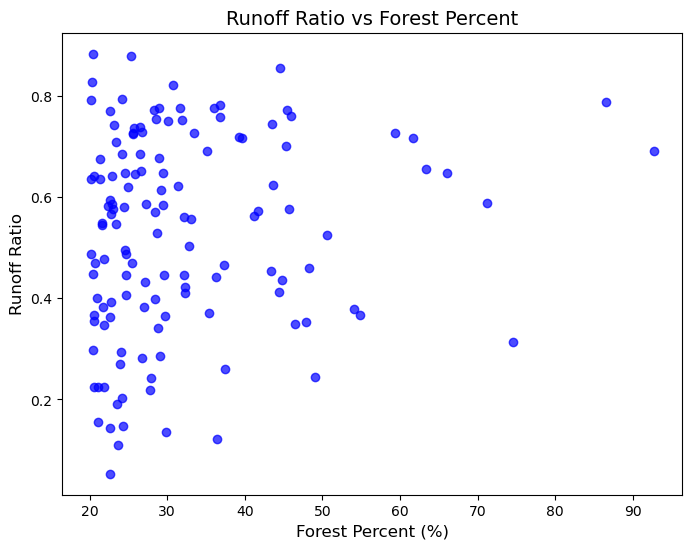

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(rr['forest_perc'], rr['runoff_ratio'], color='blue', alpha=0.7, label='Data Points')

# Add labels and title
plt.xlabel('Forest Percent (%)', fontsize=12)
plt.ylabel('Runoff Ratio', fontsize=12)
plt.title('Runoff Ratio vs Forest Percent', fontsize=14)
plt.show()

It looks as though there might be a nonlinear relationship here. From a theoretical standpoint we would expect the runoff ratio to decrease with forest cover becauses forests evaporate more water than other land cover types. So, clearly, there are additional complexities that we haven't considered in our simple model.